#loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!gdown --id 16fcKbkqAvxq6yHlpIfcvbLe6Y1Aco0sZ

Mounted at /content/drive
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16fcKbkqAvxq6yHlpIfcvbLe6Y1Aco0sZ
To: /content/imdb-reviews.csv
100% 61.9M/61.9M [00:00<00:00, 69.8MB/s]


In [ ]:
#!pip install torch==1.7.1
#!pip install torchtext==0.8.1
import torch
import torchtext 
from torchtext import data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 1234
import pandas as pd
import numpy as np
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext

import nltk

import random
from sklearn.metrics import classification_report


%matplotlib inline  



In [ ]:
import pandas as pd

df = pd.read_csv('imdb-reviews.csv',sep='\t')


#create a column called sentiment

In [ ]:
def categorise(row):  
    if row['rating'] >= 0.0 and row['rating'] <= 4.0:
        return 0
    else:
        return 1
df['sentiment'] = df.apply(lambda row: categorise(row), axis=1)
df.head()

,url,rating,review,sentiment
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...,1
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...,1
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...,1
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...,0
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...,1


In [ ]:
df=df[["review", "sentiment"]]
df.head()

,review,sentiment
0,I thought this was a quiet good movie. It was ...,1
1,Wagon Master is a very unique film amongst Joh...,1
2,This film has to be as near to perfect a film ...,1
3,I gave this 4 stars because it has a lot of in...,0
4,This movie is really genuine and random. It's ...,1


#Split into train and validation

In [ ]:


o_class = df.loc[df.sentiment == 0, :]
l_class = df.loc[df.sentiment == 1, :]


valid_o = o_class.iloc[19500:, :]
valid_l = l_class.iloc[19508:, :]

train_o = o_class.iloc[:19500, :]
train_l = l_class.iloc[:19508, :]

In [ ]:
train = pd.concat([train_o, train_l], axis=0)
print(train.shape)

valid = pd.concat([valid_o, valid_l], axis=0)
print(valid.shape)


(39008, 2)
(6000, 2)


In [ ]:


!mkdir torchtext_data



In [ ]:
train.to_csv("torchtext_data/train.csv", index=False)
valid.to_csv("torchtext_data/valid.csv", index=False)

In [ ]:
del df, train, valid, train_l, train_o,  valid_l,valid_o, o_class, l_class

#Spacy tokenizer

In [ ]:

#!pip install spacy==2.3.1
#!python -m spacy download en
#!pip show spacy
import spacy
nlp = spacy.load('en')

In [ ]:



TEXT = data.Field(sequential=True, tokenize="spacy",lower=True,batch_first=True)
LABEL = data.LabelField(dtype=torch.long, sequential=False,batch_first=True)


/usr/local/lib/python3.8/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.8/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:


# loading train, test and validation data 
train_data, valid_data = data.TabularDataset.splits(
    path="torchtext_data/", train="train.csv", 
    validation="valid.csv",format="csv", skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)]
)



/usr/local/lib/python3.8/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.8/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(valid_data)}')


Number of training examples: 39008
Number of valid examples: 6000


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip





--2023-01-08 16:16:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-08 16:16:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-08 16:16:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
TEXT.build_vocab(train_data, vectors=torchtext.vocab.Vectors("glove.6B.50d.txt"), 
                 max_size=20000, min_freq=5)
LABEL.build_vocab(train_data)


100%|█████████▉| 399999/400000 [00:09<00:00, 40753.14it/s]


In [ ]:


print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")



Unique tokens in TEXT vocabulary: 20002
Unique tokens in LABEL vocabulary: 2


In [ ]:
BATCH_SIZE = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# keep in mind the sort_key option 
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), sort_key=lambda x: len(x.Text),
    batch_size=BATCH_SIZE,
    device=device)

/usr/local/lib/python3.8/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:


LABEL.vocab.freqs

Counter({'0': 19500, '1': 19508})

#NN

In [ ]:
from unicodedata import bidirectional
class RNN2(nn.Module):
    def __init__(self, cell_type,input_dim, embedding_dim, hidden_dim, output_dim,layers):
        super().__init__()
         
        cells = {
        "RNN" : nn.RNN,
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU
    }
        self.cell_type = cell_type
        self.embedding = nn.Embedding(input_dim, embedding_dim)
       
        self.rnn = cells[cell_type](         # Pick the specific model
            input_size=embedding_dim,           # Number of features for each time step
            hidden_size=hidden_dim,         # rnn hidden units
            dropout=0.2,    #dropout probability
            batch_first=True,
            num_layers=layers
           
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.embedding(x)
        
      
        if self.cell_type == 'LSTM':
            output, (h_n, h_c) = self.rnn(embedded)
            
        else:
            output,hidden=self.rnn(embedded)
       
 
        out = self.fc(output[:, -1, :])
        return out
    

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 64
OUTPUT_DIM = 2
LAYERS=3

model = RNN2("GRU",INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,LAYERS)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([20002, 50])


In [ ]:
model.embedding.weight.data = pretrained_embeddings.cuda()

In [ ]:
model

RNN2(
  (embedding): Embedding(20002, 50)
  (rnn): GRU(50, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
class_weights = torch.tensor([1.0, 15.0]).cuda()

In [ ]:
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(weight=class_weights)


model = model.to(device)
criterion = criterion.to(device)



In [ ]:
def binary_accuracy(preds, y):
  
    preds, ind= torch.max(F.softmax(preds, dim=-1), 1)
    
    correct = (ind == y).float()
    acc = correct.sum()/float(len(correct))
    return acc,ind,y

In [ ]:
#!pip install pyprind
import pyprind

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.Text).squeeze(0)

        loss = criterion(predictions, batch.Label)

        acc,ytrue,ypred = binary_accuracy(predictions, batch.Label)
        
        loss.backward()
        #gradient clipping
        torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=10, norm_type=2.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    ytrues=[]
    ypreds=[]

    with torch.no_grad():
        bar = pyprind.ProgBar(len(iterator), bar_char='█')
        for batch in iterator:

            predictions = model(batch.Text).squeeze(0)
            
            loss = criterion(predictions, batch.Label)
            
            acc,ytrue,ypred = binary_accuracy(predictions, batch.Label)
            ytrues+=ytrue
            ypreds+=ypred
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator),ytrues,ypreds

#train

In [ ]:
N_EPOCHS = 10
epochs=[]
train_losses=[]
train_accuracies=[]
valid_losses=[]
valid_accuracies=[]

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc,yrues,ypreds = evaluate(model, valid_iterator, criterion)
    epochs.append(epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

/usr/local/lib/python3.8/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
<ipython-input-60-0038e86c81fa>:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=10, norm_type=2.0)
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40
0% [████████████████████████] 100% | ETA: 00:00:00

| Epoch: 01 | Train Loss: 0.256 | Train Acc: 49.99% | Val. Loss: 0.236 | Val. Acc: 50.00% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40
0% [████████████████████████] 100% | ETA: 00:00:00

| Epoch: 02 | Train Loss: 0.235 | Train Acc: 49.99% | Val. Loss: 0.237 | Val. Acc: 50.00% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40
0% [████████████████████████] 100% | ETA: 00:00:00

| Epoch: 03 | Train Loss: 0.236 | Train Acc: 49.96% | Val. Loss: 0.236 | Val. Acc: 50.00% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40
0% [████████████████████████] 100% | ETA: 00:00:00

| Epoch: 04 | Train Loss: 0.236 | Train Acc: 49.94% | Val. Loss: 0.234 | Val. Acc: 50.00% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40
0% [████████████████████████] 100% | ETA: 00:00:00

| Epoch: 05 | Train Loss: 0.235 | Train Acc: 50.02% | Val. Loss: 0.232 | Val. Acc: 50.00% |



Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40
0% [████████████████████████] 100% | ETA: 00:00:00

| Epoch: 06 | Train Loss: 0.230 | Train Acc: 49.96% | Val. Loss: 0.276 | Val. Acc: 66.44% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40
0% [████████████████████████] 100% | ETA: 00:00:00

| Epoch: 07 | Train Loss: 0.131 | Train Acc: 70.91% | Val. Loss: 0.129 | Val. Acc: 87.51% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40
0% [████████████████████████] 100% | ETA: 00:00:00

| Epoch: 08 | Train Loss: 0.083 | Train Acc: 85.05% | Val. Loss: 0.094 | Val. Acc: 85.59% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40
0% [████████████████████████] 100% | ETA: 00:00:00

| Epoch: 09 | Train Loss: 0.057 | Train Acc: 90.57% | Val. Loss: 0.128 | Val. Acc: 89.66% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:41
0% [████████████████████████] 100% | ETA: 00:00:00

| Epoch: 10 | Train Loss: 0.043 | Train Acc: 93.24% | Val. Loss: 0.158 | Val. Acc: 90.03% |



Total time elapsed: 00:00:00


#Learning curves

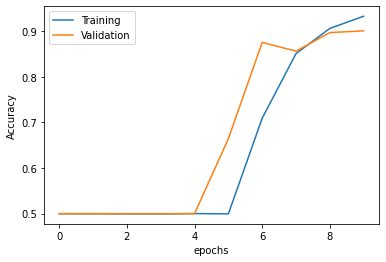

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs,train_accuracies)
plt.plot(epochs,valid_accuracies)

plt.xlabel("epochs")
plt.ylabel("Accuracy")
#plt.ylim(ymin=0)
plt.legend(["Training", "Validation"])
plt.show()

In [ ]:
y_trues=[]
y_preds=[]
for i in range(len(yrues)):
  y_trues.append(yrues[i].cpu().detach().numpy())
  y_preds.append(ypreds[i].cpu().detach().numpy())
print(y_trues)
print(y_preds)

[array(1), array(1), array(1), array(1), array(0), array(0), array(0), array(0), array(1), array(0), array(1), array(1), array(1), array(1), array(0), array(1), array(1), array(0), array(1), array(0), array(0), array(1), array(1), array(1), array(0), array(1), array(0), array(0), array(1), array(1), array(1), array(1), array(0), array(0), array(0), array(1), array(0), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(0), array(0), array(0), array(0), array(1), array(0), array(1), array(0), array(0), array(1), array(0), array(0), array(0), array(0), array(0), array(0), array(1), array(0), array(0), array(0), array(0), array(1), array(1), array(0), array(1), array(1), array(1), array(1), array(1), array(0), array(0), array(0), array(0), array(1), array(1), array(1), array(1), array(1), array(0), array(1), array(0), array(0), array(1), array(1), array(0), array(0), array(0), array(1), array(1), array(1), array(1), array(1), array(1), array(0), array(0),

0.945
0.9028662420382165
0.864329268292683


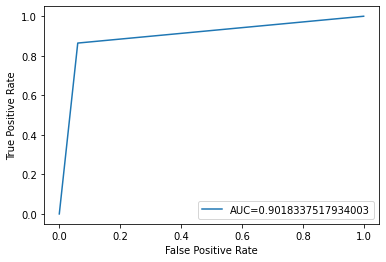

In [ ]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
print(precision_score(y_trues,y_preds))
print(f1_score(y_trues,y_preds))
print(recall_score(y_trues,y_preds))
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_trues,  y_preds)
auc = metrics.roc_auc_score(y_trues, y_preds)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()